# Historical Network Constrained Linear Optimal Power Flow

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a historical 3 day period.

In [3]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [4]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [5]:
# write csv files for import
start = '2019-12-01 00:00:00'
end = '2019-12-03 23:30:00'
# year of simulation
year = 2019
# time step as fraction of hour
time_step = 0.5

data_reader_writer is a script written to read in data from the various sources and write csv files in the format required for populating a PyPSA network object

In [6]:
data_reader_writer.data_writer(start, end, time_step, year, merge_generators=True)

C:\Users\s1100626\Anaconda3\envs\PyPSA-GB\lib\site-packages\pandas\core\indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [7]:
network = pypsa.Network()

network.import_from_csv_folder('LOPF_data')

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 19, 2], imported network file PyPSA version None.

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network LOPF_data has buses, generators, lines, loads, storage_units


To approximate n-1 security and allow room for reactive power flows, don't allow any line to be loaded above 70% of their thermal rating

In [8]:
contingency_factor = 0.7
network.lines.s_max_pu[0:99] *= contingency_factor

## Running the optimisation

In [9]:
network.lopf(network.snapshots, solver_name="gurobi", pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.03s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-19
Read LP format model from file C:\Users\s1100626\AppData\Local\Temp\pypsa-problem-y8xp1_b8.lp
Reading time = 1.07 seconds
obj: 462242 rows, 120385 columns, 816192 nonzeros
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 462242 rows, 120385 columns and 816192 nonzeros
Model fingerprint: 0x2c9b7550
Coefficient statistics:
  Matrix range     [6e-05, 1e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 9e+03]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 454360 rows and 98431 columns
Presolve time: 0.43s
Presolved: 7882 rows, 23098 columns, 46663 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.870e+04
 Factor NZ  : 1.471e+05 (roughly 14 MB of memory)
 Factor Ops : 3.808e+06 (less

INFO:pypsa.linopf:Optimization successful. Objective value: 7.11e+07


('ok', 'optimal')

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [10]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

# interconnector exports
exports = network.loads_t.p
# multiply by negative one to convert it as a generator
# i.e. export is a positive load, but negative generator
exports['Interconnectors Export'] = exports.iloc[:, -6:].sum(axis=1) * -1
interconnector_export = exports[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'] +
    p_by_carrier['Landfill Gas'] + p_by_carrier['Anaerobic Digestion'] +
    p_by_carrier['Sewage Sludge Digestion'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

p_by_carrier

carrier,Anaerobic Digestion,Biomass (co-firing),Biomass (dedicated),Coal,EfW Incineration,Interconnectors Import,Landfill Gas,Hydro,Natural Gas,Nuclear,Oil,Sewage Sludge Digestion,Shoreline Wave,Small Hydro,Solar Photovoltaics,Tidal Barrage and Tidal Stream,Wind Offshore,Wind Onshore,Pumped Storage Hydroelectric,Biomass
snapshot,,,,,,,,,,,,,,,,,,,,
2019-12-01 00:00:00,317.6,0.0,0.000,0.0,450.072,3996.000109,743.5,283.227800,12379.843579,6799.22,0.0,50.2,24.0,36.772199,0.0,10.5,2638.214991,1048.849282,2468.000000,1111.300
2019-12-01 00:30:00,317.6,0.0,0.000,0.0,450.072,3997.000108,743.5,281.457627,11570.625592,6799.22,0.0,50.2,24.0,36.542372,0.0,10.5,2526.737364,1082.545109,2468.000000,1111.300
2019-12-01 01:00:00,317.6,0.0,0.000,0.0,450.072,3997.000108,743.5,280.572540,11274.063209,6799.22,0.0,50.2,24.0,36.427459,0.0,10.5,2482.670493,1095.174159,2468.000000,1111.300
2019-12-01 01:30:00,317.6,0.0,0.000,0.0,450.072,3998.000128,743.5,280.572540,12897.538197,6799.22,0.0,50.2,24.0,36.427459,0.0,10.5,2505.758841,1101.611089,740.000000,1111.300
2019-12-01 02:00:00,317.6,0.0,0.000,0.0,450.072,3998.000128,743.5,271.721673,12560.343575,6799.22,0.0,50.2,24.0,35.278329,0.0,10.5,2530.801553,1120.762632,740.000000,1111.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-03 21:30:00,315.6,0.0,0.000,0.0,450.072,2462.999973,743.5,167.760899,23446.460289,6799.22,0.0,50.2,23.0,22.414454,0.0,10.5,2173.181209,4958.626267,839.465130,1109.300
2019-12-03 22:00:00,315.6,0.0,0.000,0.0,450.072,2158.999995,743.5,183.713623,21323.146074,6799.22,0.0,50.2,23.0,24.545891,0.0,10.5,2093.402637,4905.467416,1445.632954,1109.300
2019-12-03 22:30:00,307.4,0.0,72.708,0.0,450.072,2049.000000,717.4,218.192090,18545.072991,6783.92,0.0,50.2,23.0,22.282487,0.0,10.5,2090.567636,4853.950187,2095.734709,1147.708


In [11]:
network_generators = network.generators

network_generators.to_csv('network_generators.csv')

Graph the power output of the different generation types...

In [71]:
cols = ["Nuclear", 'Shoreline Wave', 'Biomass',
        'EfW Incineration',
        "Coal", "Oil", "Natural Gas",
        "Pumped Storage Hydroelectric", 'Hydro',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics',
        'Interconnectors Import']

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/gas oil": "black",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Anaerobic Digestion': 'green',
          'EfW Incineration': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'Interconnectors Import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

KeyError: "['Shoreline Wave', 'Coal', 'Oil'] not in index"

## Calculating emissions

This section containts the prototype cells for calculating emissions from the hourly generation mix.

In [13]:
# arrange p_by_carrier columns into alphabetical order to ensure consistency with EI factors

p_by_carrier = p_by_carrier[sorted(p_by_carrier.columns)]

In [14]:
# create a numpy array from a list of generation carriers, from top row of generation mix dataframe
carriers = np.asarray(list(p_by_carrier.columns.values))

# print(carriers)
# type(carriers)

In [15]:
# create a dataframe of emissions intensity data by reading in the emissions intensity data contained in relevant .csv
emissions_intensity = pd.read_csv('prototype_emissions.csv')

# print(emissions_intensity)
# type(emissions_intensity)

In [16]:
# remove the generation carriers that are not present in the generation mix, from the emissions intensity dataframe
emissions_intensity_LOPF = emissions_intensity[emissions_intensity['Carrier'].isin(carriers)]

# Sort emissions intensity dataframe alphabetically by Carrier to ensure consistency with generation mix dataframe
emissions_intensity.sort_values('Carrier')

# print(emissions_intensity_LOPF)
# type(emissions_intensity_LOPF)

,Carrier,Emissions Intensity [gCO2/kWh]
0,Anaerobic Digestion,354
1,Biomass,120
2,Biomass (co-firing),120
3,Biomass (dedicated),120
20,CCGT,394
4,Coal,937
21,Diesel/gas oil,300
5,EfW Incineration,300
6,Hydro,0
7,Interconnectors Import,171


In [17]:
# Create a numpy array of only the emissions intensity (EI) factors from the emissions intensity dataframe
EI_factors = emissions_intensity_LOPF['Emissions Intensity [gCO2/kWh]'].to_numpy()

# print(EI_factors)
# type(EI_factors)

In [18]:
# Create energy generation mix dataframe by multiplying power generation mix by the time step [MWh]
E_by_carrier = p_by_carrier.multiply(time_step)

# print(E_by_carrier)

In [19]:
# Create emissions dataframe. Multiply all columns in the energy dataframe by the numpy array of emissions intensity factors
Emit_by_carrier = E_by_carrier.multiply(EI_factors, axis=1)

# print(Emit_by_carrier)

In [20]:
# Convert gCO2/kWh * MWh to teCO2; the quotient of kWh:MWh (1e3) and gCO2:teCO2 (1e6) = 1e3
Emit_by_carrier_te = Emit_by_carrier.div(1e3)

# print(Emit_by_carrier_te)

KeyError: 'CCGT'

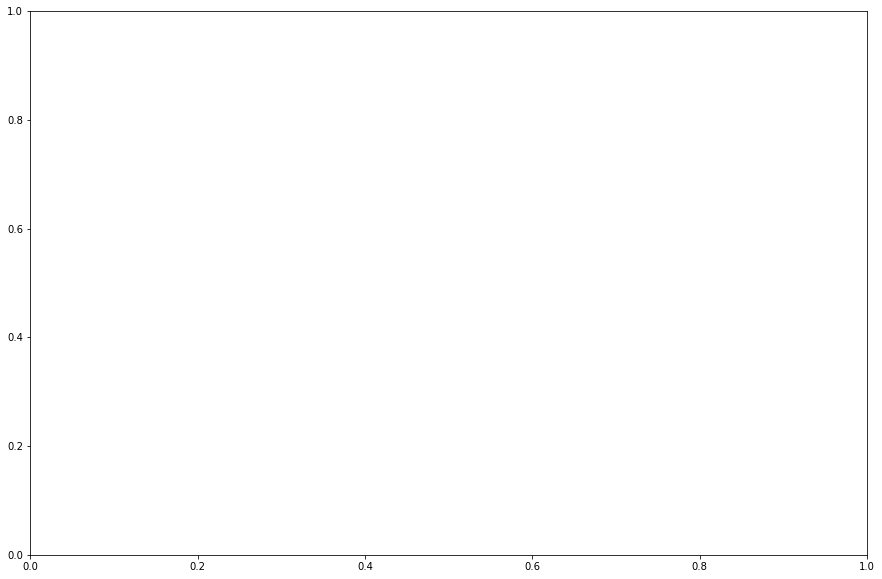

In [68]:
# sum all generator emissions per hour to get total emissions per hour
# plot results

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(Emit_by_carrier_te).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in Emit_by_carrier_te.columns])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("tonne CO2")

ax.set_xlabel("")

From the emissions and power generation at each time step, the grid-wide instantaneous emissions intensity can now be calculated.


In [22]:
# print(Emit_by_carrier_te)
# Emit_by_carrier_te.to_csv('Emit_by_carrier_te.csv')

In [23]:
# Emissions in tonnes at each time step
Emit_t_te = Emit_by_carrier_te.sum(axis=1)

# print(Emit_total_te)

In [24]:
# Energy delivered to the grid at each time step
E_t = E_by_carrier.sum(axis=1)

# print(E_t)

In [25]:
# The grid-wide emissions intensity in gCO2/kWh at each time step is given by:
epsilon_t_gCO2 = Emit_t_te * 1e3 / E_t

epsilon_t_gCO2.to_csv('epsilon_t_gCO2.csv')
# print(epsilon_t_gCO2)

In [26]:
# Average emissions intensity over the period, method 1 = quotient of sums:
epsilon_average_gCO2 = 1e3 * sum(Emit_t_te) / sum(E_t)

print("Method 1 = ", epsilon_average_gCO2, "gCO2/kWh")

# Average emissions intensity over the period, method 2 = mean of dataframe:
print("Method 2 = ", epsilon_t_gCO2.mean(), "gCO2/kWh")

Method 1 =  226.42511873449666 gCO2/kWh
Method 2 =  222.06520167938055 gCO2/kWh


## Plotting locational emissions intensities

The emissions intensity arising at each node can be calculated by inspection of the generation mix at each node.

In [27]:
# What is the generation mix at each node at each timestep?  How do I find this?

In [28]:
# 1) Isolate generators_t.p
# 2) append an array of buses, that matches the generators
# 3) append an array of types, that matches the generators
# 4) isolate by bus
# 5) sum all types within each bus
# 6) assign an emissions intensity to each type
# 7) multiply the emissions intensity by the total power of each type

In [29]:
# Isolate generators_t.p, the time series of real power generation from each individual generator
generator_mix = network.generators_t.p

# generator_mix.to_csv('generator_mix.csv')
# print(generator_mix)

In [30]:
# Isolate a dataframe of buses with the same sequence/indexing of generators as the generation time series
generators_by_bus = network.generators.bus

# print(generators_by_bus.unique())
# len(generators_by_bus.unique()) - 30 unique buses in this dataframe, 5 interconnector nodes excluded

In [31]:
# Isolate a dataframe of types with the same sequence/indexing of generators as the generation time series
generators_by_type = network.generators.type

# print(generators_by_type)

In [32]:
# Append the buses and types at the extreme end of the time series of real power generation, one after the other
generator_mix.loc[len(generator_mix)] = generators_by_bus
generator_mix.loc[len(generator_mix)] = generators_by_type

# generator_mix.to_csv('generator_mix.csv')
# print(generator_mix)

In [33]:
# there are currently 35 discrete buses; 30 generators and 5 interconnectors
# buses = network.bus.generators_by_bus.unique()
buses = network.buses
buses = buses.index

print(buses)
len(buses)

Index(['Beauly', 'Peterhead', 'Errochty', 'Denny/Bonnybridge', 'Neilston',
       'Strathaven', 'Torness', 'Eccles', 'Harker', 'Stella West',
       'Penwortham', 'Deeside', 'Daines', 'Th. Marsh/Stocksbridge',
       'Thornton/Drax/Eggborough', 'Keadby', 'Ratcliffe', 'Feckenham',
       'Walpole', 'Bramford', 'Pelham', 'Sundon/East Claydon', 'Melksham',
       'Bramley', 'London', 'Kemsley', 'Sellindge', 'Lovedean', 'S.W.Penisula',
       'Netherlands', 'Belgium', 'France1', 'France2', 'Ireland',
       'N. Ireland'],
      dtype='object', name='Bus')


35

In [34]:
# there are currently 20 discrete types, *** but not including three marine types or floating wind here ***
types = generators_by_type.unique()
print(types)
len(types)

['Conventional Steam' 'AGR' 'PWR' 'OCGT' 'CCGT' 'Diesel/gas oil'
 'Anaerobic Digestion' 'EfW Incineration' 'Landfill Gas'
 'Sewage Sludge Digestion' 'Shoreline Wave'
 'Tidal Barrage and Tidal Stream' 'Biomass (co-firing)'
 'Biomass (dedicated)' 'Wind Offshore' 'Wind Onshore'
 'Solar Photovoltaics' 'Large Hydro' 'Small Hydro' 'Interconnector']


20

In [35]:
# 20 types and 30 buses identified above
# 5 buses are interconnectors and thus not necessary to model, or should have permanent emissions intensity assigned?
# stepping through the generation mix of each bus in turn...

# note that onshore wind and offshore wind are aggregated at this stage - requires amendment for Floating Wind...

bus_1 = generator_mix.loc[ : , [(generator_mix[col] == buses[1]).any() for col in generator_mix.columns]] 
# bus_2 = generator_mix.loc[ : , [(generator_mix[col] == buses[2]).any() for col in generator_mix.columns]] 
# bus_3 = generator_mix.loc[ : , [(generator_mix[col] == buses[3]).any() for col in generator_mix.columns]] 

# ... etc

print(bus_1)
# print(bus_2)
# print(bus_3)

# ... etc

# bus_1.to_csv('bus1.csv') # Beauly generation mix time series by type, 
# bus_2.to_csv('bus2.csv') # Peterhead generation mix time series by type
# bus_3.to_csv('bus3.csv') # Errochty generation time mix series by type

# ... etc


# the final rows in these dataframes still have the 'bus' and 'type' - but this removed below

Generator            Peterhead        Kirkwall         Lerwick  \
snapshot                                                         
2019-12-01 00:00:00        0.0             0.0             0.0   
2019-12-01 00:30:00        0.0             0.0             0.0   
2019-12-01 01:00:00        0.0             0.0             0.0   
2019-12-01 01:30:00        0.0             0.0             0.0   
2019-12-01 02:00:00        0.0             0.0             0.0   
...                        ...             ...             ...   
2019-12-03 22:30:00        0.0             0.0             0.0   
2019-12-03 23:00:00        0.0             0.0             0.0   
2019-12-03 23:30:00        0.0             0.0             0.0   
144                  Peterhead       Peterhead       Peterhead   
145                       CCGT  Diesel/gas oil  Diesel/gas oil   

Generator           Glenfiddich Distillery     Black Dog  \
snapshot                                                   
2019-12-01 00:00:00  

In [36]:
bus_1.columns = bus_1.iloc[-1] # move the final row to become the column headers
print(bus_1)

145                       CCGT  Diesel/gas oil  Diesel/gas oil  \
snapshot                                                         
2019-12-01 00:00:00        0.0             0.0             0.0   
2019-12-01 00:30:00        0.0             0.0             0.0   
2019-12-01 01:00:00        0.0             0.0             0.0   
2019-12-01 01:30:00        0.0             0.0             0.0   
2019-12-01 02:00:00        0.0             0.0             0.0   
...                        ...             ...             ...   
2019-12-03 22:30:00        0.0             0.0             0.0   
2019-12-03 23:00:00        0.0             0.0             0.0   
2019-12-03 23:30:00        0.0             0.0             0.0   
144                  Peterhead       Peterhead       Peterhead   
145                       CCGT  Diesel/gas oil  Diesel/gas oil   

145                  Anaerobic Digestion  Landfill Gas  Landfill Gas  \
snapshot                                                             

In [37]:
bus_1_types = bus_1.columns.unique()
print(bus_1_types)
print(len(bus_1_types))

Index(['CCGT', 'Diesel/gas oil', 'Anaerobic Digestion', 'Landfill Gas',
       'Tidal Barrage and Tidal Stream', 'Biomass (dedicated)',
       'Wind Offshore', 'Wind Onshore', 'Solar Photovoltaics'],
      dtype='object', name=145)
9


In [38]:
bus_1_types[0]

'CCGT'

In [39]:
bus_1_type_1 = bus_1[[col for col in bus_1.columns if bus_1_types[0] in col]].sum(axis=1)
bus_1_type_1 = bus_1_type_1.drop(bus_1_type_1.index[[-1,-2]])  # removing the strings from the bottom two rows

# bus_1_type_1.columns = ['snapshot', 'CCGT'] # attempt to rename column to CCGT - seems to fail

# bus_1_type_1.to_csv('bus_1_type_1.csv')
# print(bus_1_type_1)
# type(bus_1_type_1)
# something weird going on with original node generation mix time series???  02/12/2019 10:30 are not equal!

In [40]:
bus_1_type_2 = bus_1[[col for col in bus_1.columns if bus_1_types[1] in col]].sum(axis=1)
bus_1_type_2 = bus_1_type_2.drop(bus_1_type_2.index[[-1,-2]])  # removing the strings from the bottom two rows

# display(bus_1_type_2)
# type(bus_1_type_2)

In [41]:
bus_1_type_1_df = bus_1_type_1.to_frame(name = bus_1_types[0])
bus_1_type_2_df = bus_1_type_2.to_frame(name = bus_1_types[1])

#concatenate three Series into one DataFrame
bus_1_types = pd.concat([bus_1_type_1_df, bus_1_type_2_df], axis=1)
print(bus_1_types)

                    CCGT Diesel/gas oil
snapshot                               
2019-12-01 00:00:00  0.0            0.0
2019-12-01 00:30:00  0.0            0.0
2019-12-01 01:00:00  0.0            0.0
2019-12-01 01:30:00  0.0            0.0
2019-12-01 02:00:00  0.0            0.0
...                  ...            ...
2019-12-03 21:30:00  0.0            0.0
2019-12-03 22:00:00  0.0            0.0
2019-12-03 22:30:00  0.0            0.0
2019-12-03 23:00:00  0.0            0.0
2019-12-03 23:30:00  0.0            0.0

[144 rows x 2 columns]


In [42]:
# arrange nodal generation mix columns into alphabetical order to ensure consistency with EI factors

bus_1_types = bus_1_types[sorted(bus_1_types.columns)]

In [43]:
# create a numpy array from a list of generation types, from top row of generation mix dataframe
types = np.asarray(list(bus_1_types.columns.values))

print(types)
# type(types)

['CCGT' 'Diesel/gas oil']


In [44]:
# create a dataframe of emissions intensity data by reading in the emissions intensity data contained in relevant .csv
# issue here that there is inconsistency with carriers/types which Iain will need to address in input data
emissions_intensity = pd.read_csv('prototype_emissions.csv')

print(emissions_intensity)
# type(emissions_intensity)

                           Carrier  Emissions Intensity [gCO2/kWh]
0              Anaerobic Digestion                             354
1                          Biomass                             120
2              Biomass (co-firing)                             120
3              Biomass (dedicated)                             120
4                             Coal                             937
5                 EfW Incineration                             300
6                            Hydro                               0
7           Interconnectors Import                             171
8                     Landfill Gas                             300
9                      Natural Gas                             394
10                         Nuclear                               0
11                             Oil                             935
12    Pumped Storage Hydroelectric                               0
13         Sewage Sludge Digestion                            

In [45]:
# remove the generation carriers that are not present in the generation mix, from the emissions intensity dataframe
emissions_intensity_LOPF_bus_1 = emissions_intensity[emissions_intensity['Carrier'].isin(types)]

# Sort emissions intensity dataframe alphabetically by Carrier to ensure consistency with generation mix dataframe
emissions_intensity.sort_values('Carrier')

print(emissions_intensity_LOPF_bus_1)
# type(emissions_intensity_LOPF)

           Carrier  Emissions Intensity [gCO2/kWh]
20            CCGT                             394
21  Diesel/gas oil                             300


In [46]:
# Create a numpy array of only the emissions intensity (EI) factors from the emissions intensity dataframe
EI_factors = emissions_intensity_LOPF_bus_1['Emissions Intensity [gCO2/kWh]'].to_numpy()

print(EI_factors)
# type(EI_factors)

[394 300]


In [56]:
# Create energy generation mix dataframe by multiplying power generation mix by the time step [MWh]
E_by_carrier = bus_1_types.multiply(time_step)

# print(E_by_carrier)
E_by_carrier.to_csv('E_by_carrier.csv')

In [48]:
# Create emissions dataframe. Multiply all columns in the energy dataframe by the numpy array of emissions intensity factors
Emit_by_carrier = E_by_carrier.multiply(EI_factors, axis=1)

# print(Emit_by_carrier)

In [55]:
# Convert gCO2/kWh * MWh to teCO2; the quotient of kWh:MWh (1e3) and gCO2:teCO2 (1e6) = 1e3
Emit_by_carrier_te = Emit_by_carrier.div(1e3)

print(Emit_by_carrier_te)
Emit_by_carrier_te.to_csv('Emit_by_carrier_te.csv')

                    CCGT Diesel/gas oil
snapshot                               
2019-12-01 00:00:00  0.0            0.0
2019-12-01 00:30:00  0.0            0.0
2019-12-01 01:00:00  0.0            0.0
2019-12-01 01:30:00  0.0            0.0
2019-12-01 02:00:00  0.0            0.0
...                  ...            ...
2019-12-03 21:30:00  0.0            0.0
2019-12-03 22:00:00  0.0            0.0
2019-12-03 22:30:00  0.0            0.0
2019-12-03 23:00:00  0.0            0.0
2019-12-03 23:30:00  0.0            0.0

[144 rows x 2 columns]


In [70]:
# Graphing didn't work for some reason...

(Emit_by_carrier_te).plot(kind="area", ax=ax, linewidth=0)



<AxesSubplot:xlabel='snapshot'>

From the emissions and power generation at each time step, the grid-wide instantaneous emissions intensity can now be calculated.


In [ ]:
# print(Emit_by_carrier_te)
# Emit_by_carrier_te.to_csv('Emit_by_carrier_te.csv')

In [58]:
# Emissions in tonnes at each time step
Emit_t_te = Emit_by_carrier_te.sum(axis=1)

# print(Emit_total_te)

In [59]:
# Energy delivered to the grid at each time step
E_t = E_by_carrier.sum(axis=1)

# print(E_t)

In [60]:
# The grid-wide emissions intensity in gCO2/kWh at each time step is given by:
epsilon_t_gCO2 = Emit_t_te * 1e3 / E_t

epsilon_t_gCO2.to_csv('epsilon_t_gCO2.csv')
# print(epsilon_t_gCO2)

In [61]:
# Average emissions intensity over the period, method 1 = quotient of sums:
epsilon_average_gCO2 = 1e3 * sum(Emit_t_te) / sum(E_t)

print("Method 1 = ", epsilon_average_gCO2, "gCO2/kWh")

# Average emissions intensity over the period, method 2 = mean of dataframe:
print("Method 2 = ", epsilon_t_gCO2.mean(), "gCO2/kWh")

Method 1 =  393.9999999999999 gCO2/kWh
Method 2 =  394.0 gCO2/kWh


In [ ]:
# Now just need to...
# set up loops to perform this for every type of generation at every node
# note compatibility with carriers/types to be resolved & amended in EI data

In [ ]:
# power_bus_1 = bus_1.loc[ : , [(bus_1[col] == 'Wind Onshore').any() for col in bus_1.columns]]


# power_bus_1 = power_bus_1.drop(power_bus_1.index[[-1,-2]])
# print(power_bus_1)

In [ ]:
# # isolate the real power time series of each generator type at one bus...

# # https://datagy.io/pandas-select-columns/
# for i in buses:
#     bus_i = generator_mix.loc[ : , [(generator_mix[col] == buses[1]).any() for col in generator_mix.columns]]
# print(bus_rand)

# # There must be a way to do this for a list of buses!

In [ ]:
# # isolate the real power time series of each generator type at one bus...

# bus_rand = generator_mix.loc[ : , [(generator_mix[col] == 'Keadby').any() for col in generator_mix.columns]]
# print(bus_rand)

# # There must be a way to do this for a list of buses!

In [ ]:
# # sum every 'type' in bus_rand
# power_bus_rand = bus_rand.loc[ : , [(bus_rand[col] == 'Wind Onshore').any() for col in bus_rand.columns]]
# power_bus_rand = power_bus_rand.drop(power_bus_rand.index[[-1,-2]])
# print(power_bus_rand)

In [ ]:
# # remove all buses except Beauly from the generators dataframe
# bus_of_interest = 'Beauly'
# Beauly_generators = buses[buses['bus'].isin(bus_of_interest)]


In [ ]:
# # Time series of the real power, p, at each bus (but no description of Carrier)
# print(network.generators_t.p.groupby(network.generators.bus, axis=1).sum())

In [ ]:
# Code copied from marginal price mapping...

# fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
# fig.set_size_inches(20, 10)

# network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
# plt.hexbin(network.buses.x, network.buses.y,
#            gridsize=20,
#            C=network.buses_t.marginal_price.loc[now], # Note here from within 'network' object exists 'marginal_price'
#            cmap=plt.cm.jet)

# # for some reason the colorbar only works with graphs plt.plot
# # and must be attached plt.colorbar

# cb = plt.colorbar()
# cb.set_label('Locational Marginal Price (£/MWh)')

## Plotting storage

Graph the pumped hydro dispatch and state of charge...

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

p_storage = network.storage_units_t.p.sum(axis=1)
state_of_charge = network.storage_units_t.state_of_charge.sum(axis=1)
p_storage.plot(label="Pumped hydro dispatch", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("MWh")
ax.set_xlabel("")

## Plotting line loading

Look at the line loading stats and graph...

In [ ]:
now = network.snapshots[139]

print("With the linear load flow, there is the following per unit loading:")
loading = network.lines_t.p0.loc[now] / network.lines.s_nom
loading.describe()

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(15, 17)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

## Plotting locational marginal prices

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.lines.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')

In [ ]:
network.buses_t.marginal_price

## Plotting curtailment

In [ ]:
carrier = "Wind Onshore"

capacity = network.generators.groupby("carrier").sum().at[carrier, "p_nom"]
p_available = network.generators_t.p_max_pu.multiply(network.generators["p_nom"])
p_available_by_carrier = p_available.groupby(network.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier
p_df = pd.DataFrame({carrier + " available": p_available_by_carrier[carrier],
                     carrier + " dispatched": p_by_carrier[carrier],
                     carrier + " curtailed": p_curtailed_by_carrier[carrier]})

p_df[carrier + " capacity"] = capacity
p_df["Wind Onshore curtailed"][p_df["Wind Onshore curtailed"] < 0.] = 0.
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
p_df[[carrier + " dispatched", carrier + " curtailed"]].plot(kind="area", ax=ax, linewidth=0)

ax.set_xlabel("")
ax.set_ylabel("Power [MW]")
ax.legend()